In [51]:
import numpy as np
import scipy as sp

from scipy import stats

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

## Task 1: Bayesian inference with MCMC

We will consider a simple case of Bayesian inference for the unknown mean parameter of a Normal distribution. A series of values $\boldsymbol{X}^{(n)} = X_1, X_2, \dots X_n$ is sampled **independently** from a Normal distribution and we know its variance in advance, but are unsure about the mean. We assign a prior distribution to this unknown mean and would like to infer its posterior. We are also interested in predicting future observations $X$, so we would like to obtain its posterior predictive distribution as well.
$$\mu \sim \mathcal{N}(\mu_0, \sigma_0^2)$$
$$X_i | \mu \sim \mathcal{N}(\mu, \sigma^2), \; i=1 \dots n.$$

In [52]:
np.random.seed(31337)

true_mu = 3.0
true_std = 0.3
n = 20

samples = np.random.normal(true_mu, true_std, n)

### Task 1.1: implement analytical posterior (1 point)

$$p(\mu | \boldsymbol{X}^{(n)}) = \frac{p(\boldsymbol{X}^{(n)} | \mu) p(\mu)}{p(\boldsymbol{X}^{(n)})}, \label{eq1} \tag{1}$$
$$p(\boldsymbol{X}^{(n)}) = \int p(\boldsymbol{X}^{(n)}, \mu) d\mu$$
For our simple case it is actually possible to derive the exact posterior distibution of the mean analytically. Posterior distiribution of $\mu$ will also be Normal, but with different parameters that will depend on the observed sample and prior parameters. Refer to https://en.wikipedia.org/wiki/Conjugate_prior for the exact formulas and implement them in the following function:

Let us denote the parameters of posterior normal distribution as $\mu_p$ and $\sigma_p^2$, then

$$\mu_p = \left[\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}\right]^{-1}
\left[\frac{\mu_0}{\sigma_0^2} + \frac{1}{\sigma^2}\sum\limits_{i = 1}^n x_i\right],\;
\sigma_p^2 = \left[\frac{1}{\sigma_0^2} + \frac{n}{\sigma^2}\right]^{-1} \Longrightarrow 
\mu|\mathcal{D} \sim p(\mu|\mathcal{D}) = \text{N}(\mu|\mu_p, \sigma_p^2)$$

In [53]:
def analytical_posterior_pdf(x, samples, sigma, mu_0, sigma_0):
    """
    Probability density of the analytical posterior for the Normal model with known variance
    
    :param x: point(s) where to evaluate the density
    :param samples: observed samples
    :param sigma: known standard deviation of the observations
    :param mu_0: mean of the prior
    :param sigma_0: standard deviation of the prior
    :return: p(mu | samples)(x)
    """
    
    # Your code code to derive the parameters
    
    n = len(samples)
    sigma_squared_0 = sigma_0 ** 2
    sigma_squared = sigma ** 2

    sigma_squared_p = 1 / (1 / sigma_squared_0 + n / sigma_squared)

    mu_p = sigma_squared_p * (mu_0 / sigma_squared_0 + np.sum(samples) / sigma_squared)
    sigma_p = np.sqrt(sigma_squared_p)
    
    return stats.norm(mu_p, sigma_p).pdf(x)

Plot the resulting analytical posterior for the given observed sample, standard deviation of $X_i$ and prior parameters.

In [54]:
prior_mu = 0.
prior_std = 1.

In [55]:
xx = np.linspace(true_mu - true_std, true_mu + true_std, num=int(1e3))
yy_analytical_parameter_posterior = analytical_posterior_pdf(xx, samples, true_std, prior_mu, prior_std)

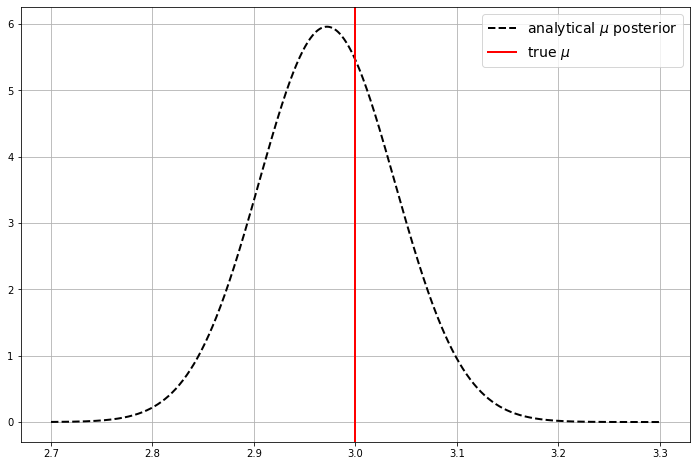

In [56]:
plt.figure(figsize=(12, 8))
plt.plot(xx, yy_analytical_parameter_posterior, ls='--', linewidth=2., color='black', label=r'analytical $\mu$ posterior')
plt.axvline(true_mu, linewidth=2., color='red', label=r'true $\mu$')

plt.legend(fontsize=14)
plt.grid()
plt.show()

### Task 1.2: Metropilis-Hastings algorithm (2 points)

In more complex models it is usually infeasible to derive the exact formula for the posterior density. In the equation (1), the numerator contains easy to evaluate terms: prior and likelihood, while the denominator is rather hard to find. This means that we know our posterior only up to a constant multiplicative term. We will have to resort to approximations. Previously in the course we have studied methods to estimate the unknown density from samples. If we could sample from this unknown posterior, we might be able to approximate it using a histogram or a kernel method.

This is precisely the goal of MCMC methods. We will construct a Markov chain that will eventually produce samples from our distribution of interest - the posterior.


Markov chain is a sequence of random variables $Y_1, Y_2, \dots$ with the following property:
$$p(Y_k | Y_{k-1}, Y_{k-2}, \dots, Y_2, Y_1) = p(Y_k | Y_{k-1}),$$
wich means that subsequent values ($Y_k$) do not depend on the whole history of the sequence if the previous value ($Y_{k-1}$) is given.

We want to start with our chain from the prior distribution $Y_1 \sim p(\mu)$ and eventually converge to the posterior $Y_k \sim p(\mu | \boldsymbol{X}^{(n)})$. In order to achieve this, we need to define the transition probabilities $p(Y_k | Y_{k-1})$ in a special way. Intuitevely, it will depend on the prior and posterior in some way and there may be different possibilities.

We will describe one way to do it, namely Metropilis-Hastings algorithm with a random walk proposal. It was introduced in lecture 10, slides 19-22. We will use it to draw a sequence of samples from a special markov chain that satisfies our requirements.

Let $T$ be the number of steps we decided to take from the chan. For our example model and using our notation the algorithm outilines as follows:

1. Start by sampling $Y_1$ from the prior $p(\mu)$
2. Repeat for each $k$ form 1 to T:
3. Construct the next sample $Y_{k+1}$ given the previous sampled value $Y_k$:
4. $Y_{k+1} = Y_{k} + Z_{k+1}$, where $Z_{k+1} \sim \mathcal{N}(0, \sigma_{step}^2)$ (we take a sample)
5. We need to decide whether to make the transition $Y_k \rightarrow Y_{k+1}$ (accept or reject our *proposed* new value $Y_{k+1}$):
6. Accept the new sample with probability $\min \left\{1, \frac{p(\boldsymbol{X}^{(n)} | \mu = Y_{k+1}) p(\mu = Y_{k+1})}{p(\boldsymbol{X}^{(n)} | \mu = Y_{k}) p(\mu = Y_{k})}\right\}$, otherwise let $Y_{k+1} = Y_k$

Notice that our acceptance probability equals the ratio of the **posterior** probabilities: $\frac{p(\mu=Y_{k+1} | \boldsymbol{X}^{(n)})}{p(\mu=Y_k | \boldsymbol{X}^{(n)})}$, since the denominator in formula (1) does not depend on $\mu$. This allows us to skip the hard part of taking the integral. 

Your task is to implement these steps, including the calculation of the acceptance probability, and run the chain. Numpy array `Y` should contain one MCMC trajectory that you have obtained as the result.

*You may need to tune the $\sigma_{step}$ parameter.

In [57]:
def acceptance_prob(y_new, y_old, samples, sigma, mu_0, sigma_0):
    """
    Calculate acceptance probability in Metropilis-Hastings step for the Normal model with known variance
    :param y_new: proposed value (corresponds to Y_{k+1})
    :param y_old: previous value (corresponds to Y_k)
    :param samples: observed data (X^(n))
    :param sigma: known standard deviation of the observations
    :param mu_0: mean of the prior
    :param sigma_0: standard deviation of the prior
    :return: p, acceptance probability
    """
    
    # numerator = analytical_posterior_pdf(y_new, samples, sigma, mu_0, sigma_0)
    numerator = np.prod(stats.norm(y_new, sigma).pdf(samples)) * stats.norm(mu_0, sigma_0).pdf(y_new)

    # denominator = analytical_posterior_pdf(y_old, samples, sigma, mu_0, sigma_0)
    denominator = np.prod(stats.norm(y_old, sigma).pdf(samples)) * stats.norm(mu_0, sigma_0).pdf(y_old)

    ratio = numerator / denominator
    return min(1, ratio)

In [58]:
n_steps = 2000
# n_steps = 10
sigma_step = 0.1

yy = np.empty(n_steps)
yy[0] = np.random.normal(prior_mu, prior_std)

acceptance_history = np.empty(n_steps)
acceptance_history[0] = 0

for i in tqdm(range(1, n_steps)):
    z = np.random.normal(0, sigma_step)

    y_old = yy[i - 1]
    y_new = y_old + z
    
    acceptance_old = acceptance_history[i - 1]
    acceptance_new = int(np.random.rand() < acceptance_prob(y_new, y_old, samples, true_std, prior_mu, prior_std))

    if acceptance_new:
        yy[i] = y_new
    else:
        yy[i] = y_old
    
    acceptance_history[i] = acceptance_old + acceptance_new

  0%|          | 0/1999 [00:00<?, ?it/s]

### Task 1.3: Visualize the results (1 point)
We have obtained a single trajectory of our Markov chain. The starting portion of the obtained values may be different from the samples of the actual posterior. After the so-called **burn-in** or **warmup** phase the distribution should become stationary and connverge to the true posterior. Time spent before this convergence occurs is usually called **mixing time**, and it is hard to estimate in practical situations.

1. Plot your trajectory using line chart: x-axis will be the timestep number and y-axis the sampled value

2. Plot the acceptance probability: how many proposed steps were accepted on average at given timestep (use sliding window or exponential moving average). Does it change over time? (You may need to save additional info during sampling in the previous part)

3. When do you think the 'mixing' occured? (Approximately)

In [59]:
tt = np.arange(n_steps)

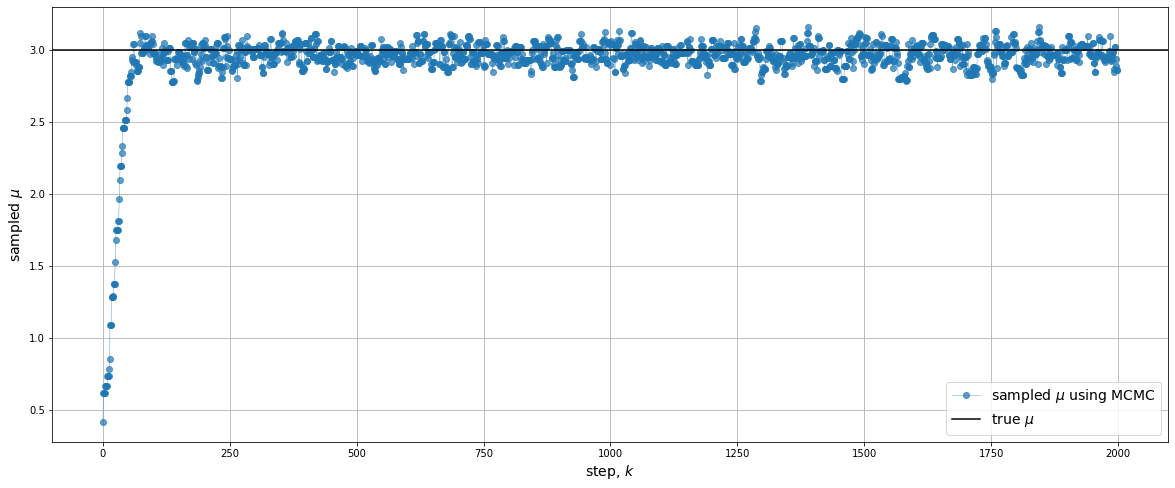

In [60]:
plt.figure(figsize=(20, 8))
plt.plot(tt, yy, marker='o', alpha=0.7, linewidth=0.5, label='sampled $\mu$ using MCMC')
plt.axhline(3., color='black', label='true $\mu$')

plt.xlabel(r'step, $k$', fontsize=14)
plt.ylabel(r'sampled $\mu$', fontsize=14)

plt.grid()
plt.legend(fontsize=14)
plt.show()

We can see that from the very first step the Markov Chain has started to converge to the target $\mu$ posterior distribution and 
has become stationary after the $100$'th or something like that

In [61]:
def exponential_moving_average(history, beta=0.5):
    n_steps = len(history)
    moving_history = np.empty(n_steps)
    moving_history[0] = history[0]

    for i in range(1, n_steps):
        moving_history[i] = beta * history[i] + (1 - beta) * moving_history[i - 1]
    
    return moving_history

In [62]:
moving_acceptance_history = exponential_moving_average(acceptance_history[1:] / tt[1:])

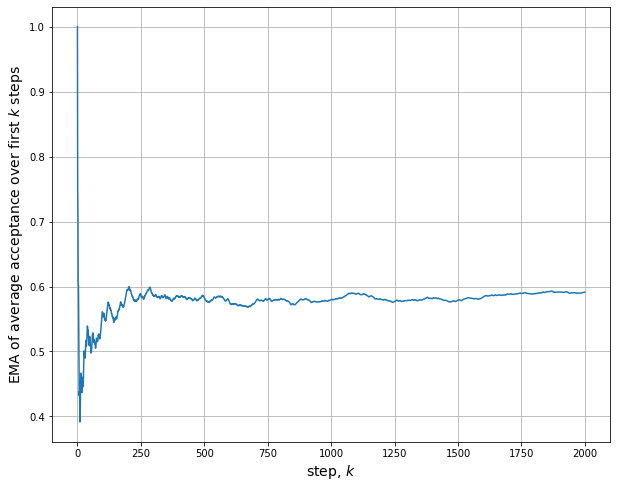

In [63]:
plt.figure(figsize=(10, 8))
plt.plot(tt[1:], moving_acceptance_history)

plt.xlabel(r'step, $k$', fontsize=14)
plt.ylabel(r'EMA of average acceptance over first $k$ steps', fontsize=14)

# plt.xscale('log')
plt.grid()
plt.show()

### Task 1.4: Approximate posterior (1 points)

Now we have determined the part of our trajectory that converged to our target distribution (you can use your guess from the previous task or just designate first half the trajectory for mixing). We will work with the remaing part to approximate the posterior.

1. Plot the histogram and kernel density estimator of the posterior using the samples from your MCMC run
2. Unfortunately, the samples that we obtained are not independent: due to the nature of our proposal step they are correlated. We can try to aleviate this effect by dropping some of the samples. Use only every 3rd (or 4th, 5th) obtained sample from the chain and display the corresponding distribution estimate on the same plot. Is it different?
3. Add theoretical posterior from part 1 to the same plot. Is it close to our estimate(s)?

In [64]:
mu_samples = yy[200:]
mumu = np.linspace(mu_samples.min() - 0.1, mu_samples.max() + 0.1, num=int(1e3))

kde = stats.gaussian_kde(mu_samples)
kde_estimate = kde(mumu)

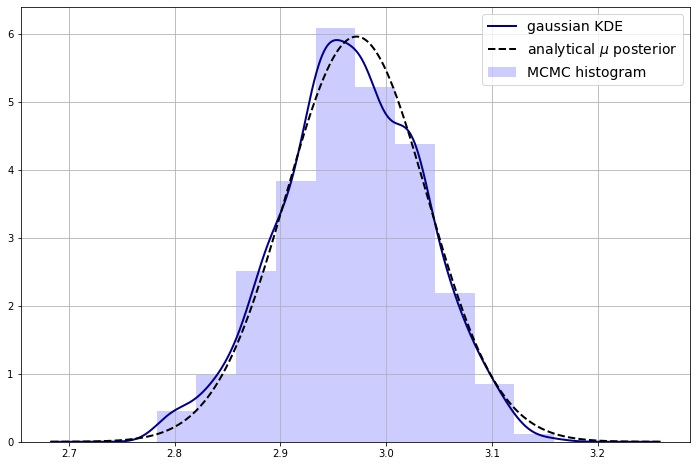

In [96]:
plt.figure(figsize=(12, 8))

plt.hist(mu_samples, bins=10, density=True, alpha=0.2, color='blue', label='MCMC histogram')
plt.plot(mumu, kde_estimate, linewidth=2., color='darkblue', label='gaussian KDE')
plt.plot(mumu, yy_analytical_parameter_posterior, ls='--', linewidth=2., color='black', label='analytical $\mu$ posterior')

plt.legend(fontsize=14)
plt.grid()
plt.show()

In [66]:
mu_samples_filtered = mu_samples[::5]

kde_filtered = stats.gaussian_kde(mu_samples_filtered)
kde_estimate_filtered = kde_filtered(mumu)

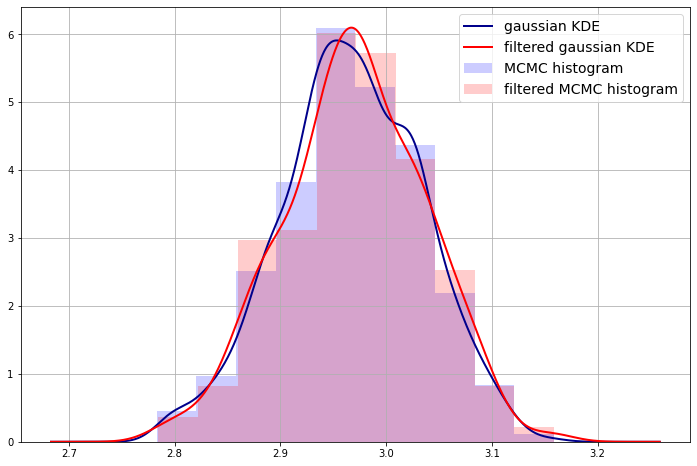

In [97]:
plt.figure(figsize=(12, 8))

plt.hist(mu_samples, bins=10, density=True, alpha=0.2, color='blue', label='MCMC histogram')
plt.hist(mu_samples_filtered, bins=10, density=True, alpha=0.2, color='red', label='filtered MCMC histogram')

plt.plot(mumu, kde_estimate, linewidth=2., color='darkblue', label='gaussian KDE')
plt.plot(mumu, kde_estimate_filtered, linewidth=2., color='red', label='filtered gaussian KDE')

plt.legend(fontsize=14)
plt.grid()
plt.show()

We can see that the filtered distribution of $\mu$ is slightly different and looks more symmetric

In [68]:
yy_analytical_parameter_posterior = analytical_posterior_pdf(mumu, samples, true_std, prior_mu, prior_std)

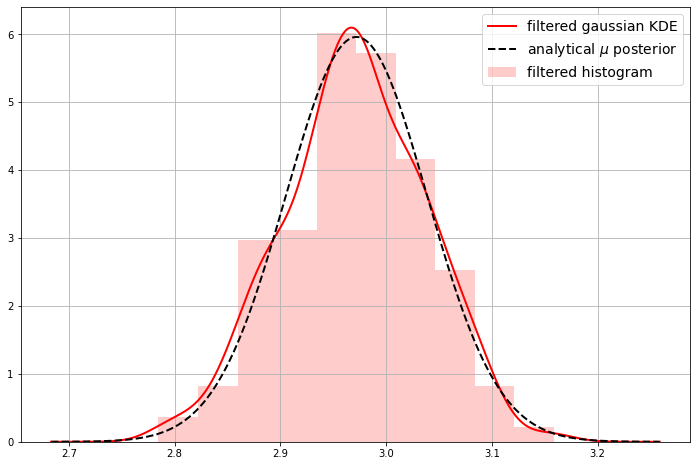

In [98]:
plt.figure(figsize=(12, 8))

plt.hist(mu_samples_filtered, bins=10, density=True, alpha=0.2, color='red', label='filtered histogram')
plt.plot(mumu, kde_estimate_filtered, linewidth=2., color='red', label='filtered gaussian KDE')
plt.plot(mumu, yy_analytical_parameter_posterior, ls='--', linewidth=2., color='black', label='analytical $\mu$ posterior')

plt.legend(fontsize=14)
plt.grid()
plt.show()

As can be seen, the distribution of MCMC samples for $\mu$ is pretty much the same as the analytical posterior distribution of $\mu$

### Task 1.5: Posterior predictive distribution (1 bonus point)

Now that we have obtained the estimate of the posterior, we can turn to a more practical task: predicting new values $X_{n+1}$. To do it in a Bayesian fashion, we employ posterior predictive distribution:
$$p(X_{n+1} | \boldsymbol{X}^{(n)}) = \int p(X_{n+1}, \mu | \boldsymbol{X}^{(n)}) d \mu = \int p(X_{n+1} | \mu, \boldsymbol{X}^{(n)}) p(\mu | \boldsymbol{X}^{(n)})d \mu = \int p(X_{n+1} | \mu) p(\mu | \boldsymbol{X}^{(n)})d \mu$$

Similar to part 1, for our simple model this distribution can also be derived analyticaly and is described on the same Wiki page.

1. Implement analytical posterior predictive distribution for our model and plot it
2. Using decorrelated samples from the posterior, obtained in the previous part, approximate the posterior predictive distribution (with histogram or KDE) and add it to the plot. Is it close to the analytical result?

The predictive posterior distribution can be expressed as
$$x|\mu \sim p(x|\mu) = \text{N}(x|\mu, \sigma^2) \Longrightarrow 
x|\mathcal{D} \sim p(x|\mathcal{D}) = \int\limits_M p(x, \mu|\mathcal{D})d\mu = \int\limits_M p(x|\mu, \mathcal{D})p(\mu|\mathcal{D})d\mu =$$
$$= \int\limits_M p(x|\mu)p(\mu|\mathcal{D})d\mu = \int\limits_M \text{N}(x|\mu, \sigma^2)\text{N}(\mu|\mu_p, \sigma_p^2)d\mu = 
\Big\langle\text{some magic from wikipedia}\Big\rangle = \text{N}(x|\mu_p, \sigma_p^2 + \sigma^2)$$

In [70]:
def predictive_analytical_posterior_pdf(x, samples, sigma, mu_0, sigma_0):
    # construct parameter posterior distribution
    n = len(samples)
    sigma_squared_0 = sigma_0 ** 2
    sigma_squared = sigma ** 2

    sigma_squared_p = 1 / (1 / sigma_squared_0 + n / sigma_squared)

    mu_p = sigma_squared_p * (mu_0 / sigma_squared_0 + np.sum(samples) / sigma_squared)
    sigma_p = np.sqrt(sigma_squared_p)

    # construct predictive posterior distribution
    sigma_squared = sigma ** 2
    sigma_squared_p = sigma_p ** 2

    mu_result = mu_p
    sigma_result = np.sqrt(sigma_squared + sigma_squared_p)
    
    return stats.norm(mu_result, sigma_result).pdf(x)

In [71]:
xx = np.linspace(true_mu - 4 * true_std, true_mu + 4 * true_std, num=int(1e3))

In [72]:
yy_analytical_predictive_posterior = predictive_analytical_posterior_pdf(xx, samples, true_std, prior_mu, prior_std)
yy_data = stats.norm.pdf(xx, loc=true_mu, scale=true_std)

In [73]:
# plt.figure(figsize=(12, 8))
# plt.plot(xx, yy_analytical_predictive_posterior, ls='-.', linewidth=2., color='blue', label='analytical predictive posterior')
# plt.plot(xx, yy_data, ls='--', linewidth=2., color='red', label='true data')

# plt.legend(fontsize=14)
# plt.grid()
# plt.show()

The MCMC predictive posterior distribution can be expressed as
$$x|\mathcal{D} \sim p(x|\mathcal{D}) = \int\limits_M p(x, \mu|\mathcal{D})d\mu = 
\int\limits_M p(x|\mu)p(\mu|\mathcal{D})d\mu \approx
\frac{1}{m}\sum\limits_{k = 1}^m p(x|\mu_k) = \frac{1}{m}\sum\limits_{k = 1}^m \text{N}(x|\mu_k, \sigma^2)$$

In [74]:
def predictive_monte_carlo_posterior_pdf(x, mu_samples, sigma):
    n_samples = len(mu_samples)
    prediction_ensemble = np.array([list(stats.norm(mu_samples[i], sigma).pdf(x)) for i in range(n_samples)])

    return prediction_ensemble.mean(axis=0)

In [75]:
yy_sampled_predictive_posterior = predictive_monte_carlo_posterior_pdf(xx, mu_samples_filtered, true_std)

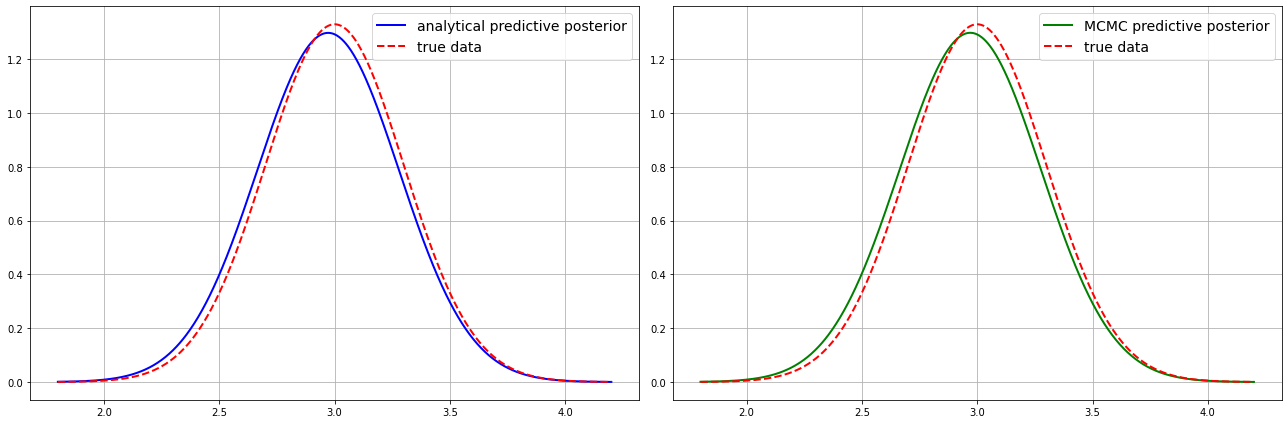

In [105]:
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

axes[0].plot(xx, yy_analytical_predictive_posterior, ls='-', linewidth=2., color='blue', label='analytical predictive posterior')
axes[0].plot(xx, yy_data, ls='--', linewidth=2., color='red', label='true data')
axes[0].legend(fontsize=14)
axes[0].grid()

axes[1].plot(xx, yy_sampled_predictive_posterior, ls='-', linewidth=2., color='green', label='MCMC predictive posterior')
axes[1].plot(xx, yy_data, ls='--', linewidth=2., color='red', label='true data')
axes[1].legend(fontsize=14)
axes[1].grid()

plt.tight_layout()
plt.show()

In [103]:
# plt.figure(figsize=(12, 8))
# plt.plot(xx, yy_sampled_predictive_posterior, ls='--', linewidth=2., color='green', label='MCMC predictive posterior')
# plt.plot(xx, yy_data, ls='-.', linewidth=2., color='red', label='true data')

# plt.legend(fontsize=14)
# plt.grid()
# plt.show()

The difference between analytical posterior distribution of $\mu$ and its MCMC approximation is almost indistinguishable.
Hence, MCMC is an excellent approach for approximating mathematical expectation such as predictive posterior

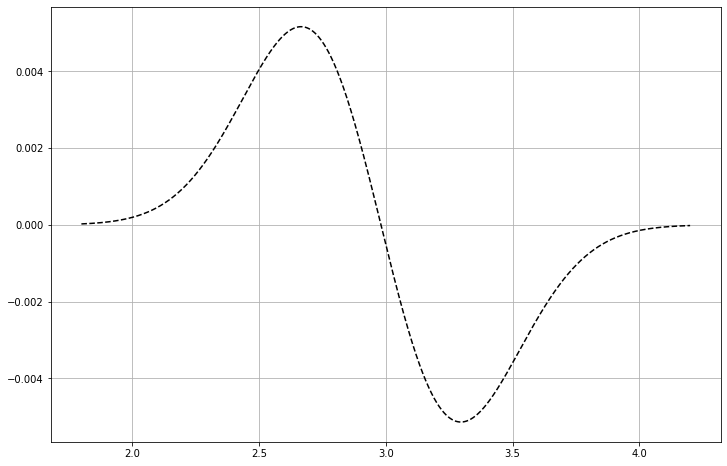

In [78]:
plt.figure(figsize=(12, 8))
plt.plot(xx, yy_sampled_predictive_posterior - yy_analytical_predictive_posterior, ls='--', color='black')

plt.grid()
plt.show()

# Task 2. Substitution Cipher and Markov Chain Monte Carlo (MCMC). (5 points)

In this task we will decrypt data that was scrambled using a Substitution Cipher. We assume that encryption key is unknown and we want to decrypt the data and read the code using recovered decryption key. [Introduction from here](http://statweb.stanford.edu/~cgates/PERSI/papers/MCMCRev.pdf) gives reference to the original task.

In [79]:
import string
import numpy as np

from tqdm.auto import tqdm

In [80]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [81]:
%cd '/content/gdrive/MyDrive/Colab Notebooks/Principles of Applied Statistics/homework-4'

/content/gdrive/MyDrive/Colab Notebooks/Principles of Applied Statistics/homework-4


As verification we will take a piece from "Alice's adventures in Wonderland". We scramble data with a random encryption key, which we forgot after encrypting, and we would like to decrypt this encrypted text using MCMC Chains.

In [82]:
plain_text = """
Alice was beginning to get very tired of sitting by her sister on the bank, and of having nothing to do: once or twice she had peeped into the book her sister was reading, but it had no pictures or conversations in it, 'and what is the use of a book,' thought Alice 'without pictures or conversation?'
So she was considering in her own mind (as well as she could, for the hot day made her feel very sleepy and stupid), whether the pleasure of making a daisy-chain would be worth the trouble of getting up and picking the daisies, when suddenly a White Rabbit with pink eyes ran close by her.
There was nothing so very remarkable in that; nor did Alice think it so very much out of the way to hear the Rabbit say to itself, 'Oh dear! Oh dear! I shall be late!' (when she thought it over afterwards, it occurred to her that she ought to have wondered at this, but at the time it all seemed quite natural); but when the Rabbit actually took a watch out of its waistcoat-pocket, and looked at it, and then hurried on, Alice started to her feet, for it flashed across her mind that she had never before see a rabbit with either a waistcoat-pocket, or a watch to take out of it, and burning with curiosity, she ran across the field after it, and fortunately was just in time to see it pop down a large rabbit-hole under the hedge.
In another moment down went Alice after it, never once considering how in the world she was to get out again.
The rabbit-hole went straight on like a tunnel for some way, and then dipped suddenly down, so suddenly that Alice had not a moment to think about stopping herself before she found herself falling down a very deep well.
"""

We will use 26 letters of English alphabet.

In [83]:
characters = string.ascii_lowercase
characters_dict = {char : c for c, char in enumerate(characters, start=1)}
m = len(characters) + 1

## Generate random encryption key.

Here are functions that will be used to encrypt/decrypt text.

In [84]:
def encode_text(text_to_encode, characters_dict):
    """This function turns a text string into an integer sequence using given dictionary."""
    characters_set = set(characters_dict.keys())
    return np.r_[[characters_dict[char] if char in characters_set else 0 for char in text_to_encode.strip().lower()]]

def decode_text(text_to_decode, characters):
    """This function turns an integer sequence into a text string using given list of characters."""
    characters_array = np.array([" "] + list(characters))
    return "".join(characters_array[text_to_decode])

def apply_cipher(text_as_int_array, cipher):
    "This function applies substitution cipher to an integer sequence."
    return cipher[text_as_int_array]

Generate encryption and decryption keys. They are just permutations of the alphabet.

In [85]:
np.random.seed(1234)

encryption_indices = np.random.permutation(np.arange(m - 1))
decryption_indices = np.argsort(encryption_indices)

characters_array = np.array(list(characters))
encryption_key = "".join(characters_array[encryption_indices])
decryption_key = "".join(characters_array[decryption_indices])

Check encoding/decoding functions and encryption/decryption keys.

In [86]:
encryption_key_encoded = np.r_[0, encode_text(encryption_key, characters_dict)]
decryption_key_encoded = np.r_[0, encode_text(decryption_key, characters_dict)]

text = "The quick brown fox jumps over the lazy dog"

encoded_text = encode_text(text, characters_dict)
cipher_text = apply_cipher(encoded_text, encryption_key_encoded)
encoded_text = apply_cipher(cipher_text, decryption_key_encoded)
decoded_text = decode_text(encoded_text, characters_dict)

In [87]:
decoded_text

'the quick brown fox jumps over the lazy dog'

Encrypt cipher text.

In [88]:
plain_text_encoded = encode_text(plain_text, characters_dict)
cipher_text = apply_cipher(plain_text_encoded, encryption_key_encoded)

## Collect frequences 

Collect frequences of two character combinations (bigrams) over large text corpus and from encrypted text. We will store them in a matrix and interpret it as a transition matrix: from the first character to the second.

In [89]:
def collect_transition_frequences(data, transition_matrix):
    """For a given integer sequence, which corresponds to some char sequence, 
       return transitions for adjacent values."""
    transitions = data.repeat(2)[1:-1].reshape(-1, 2)
    for i, j in transitions:
        transition_matrix[i, j] += 1
    
    return transition_matrix

def collect_empirical_frequences(filename, characters_dict, m):
    """Collect frequences over large text corpus, return transition matrix."""
    transition_matrix = np.zeros((m, m))
    with open(filename) as f:
        for line in f:
            line_encoded = encode_text(line, characters_dict)
            if line_encoded.size > 1:
                transition_matrix = collect_transition_frequences(line_encoded, transition_matrix)
                
    return transition_matrix

def collect_observed_frequences(cipher_text, characters_dict, m):
    """Collect frequences over encrypted text, return nonzero indices of 
       transition matrix for both dimentions and values for those indices.
       `values = transition_matrix[indices_1, indices_2]`"""
    transition_matrix = np.zeros((m, m))
    transition_matrix = collect_transition_frequences(cipher_text, transition_matrix)
    
    return transition_matrix

Collect frequences.

In [90]:
empirical_frequences = collect_empirical_frequences('war-and-peace.txt', characters_dict, m)
observed_frequences = collect_observed_frequences(cipher_text, characters_dict, m)

## General algorithm

Our Chain will include states that are permutations of the substitution cipher. Algorithm has following steps:

1. Start by picking up a random current state. 
2. Create a proposal for a new state by swapping two or more random letters in the current state.
3. Use a Scoring Function which calculates the score of the current state $Score_{old}$ and the proposed state $Score_{new}$.
4. If the score of the proposed state is more than current state, Move to Proposed State.
5. Else flip a coin which has a probability of heads $\frac{Score_{new}}{Score_{old}}$  . If it comes heads move to proposed State.
6. Repeat from Step 2.

We want to reach a steady state where the chain has the stationary distribution of the needed states. This state of chain could be used as a solution.

Let's start with implementing steps 2 and 3.

## Step 2: Prepare sampling function (2 points).



To generate a new proposed cipher we randomly select several positions and swap values at those positions. It corresponds to change in several mappings of encrypted characters in decrypted ones. Example with 2 swaps.

was|now
-|-
A -> B | A -> B
B -> C | B -> C
C -> D | C -> A
D -> A | D -> D

In [91]:
def generate_cipher(cipher, m, size=2):
    """
    Swap two or more random positions in cipher.
        
    cipher, np.array - current mapping from value(int) in encrypted text (index of array cell) 
                       into value(int) in decrypted text(value of array cell)

    m, int - capacity of used alphabet,
    size, int - number of positions to change.
    """
    
    indices = np.random.choice(np.arange(1, m), size, replace=False)
    permutation = np.random.permutation(indices)

    new_cipher = cipher.copy()
    new_cipher[indices] = new_cipher[permutation]
    
    return new_cipher

## Step 3: Prepare scoring function (2 points).

We want to use a scoring function for each state(Decryption key) which assigns a positive score to each decryption key. This score intuitively should be larger if the encrypted text looks more like actual english, when decrypted using this decryption key. We will check a large text and calculate frequences: how many times one character comes after another in a large text like "War and Peace".

For each pair of characters $\beta_1$ and $\beta_2$ (e.g. $\beta_1$ = A and $\beta_2$ = B), we let $R(\beta_1,\beta_2)$ record the number of times that specific pair(e.g. "AB") appears consecutively in the reference text.

Similarly, for a considered decryption key $x$, we let $F_x(\beta_1,\beta_2)$ record the number of times that
pair appears when the cipher text is decrypted using the decryption key $x$.

We then Score a particular decryption key $x$ using:

$$Score(x) = \prod R(\beta_1,\beta_2)^{F_x(\beta_1,\beta_2)}$$
    
To make life easier with calculations we will calculate $\log(Score(x))$

Now, you need to implement scoring function. As input it takes 
- `cipher`: mapping between encrypted characters and decrypted characters,
- `observed_frequences`: transition matrix for cipher text, matrix representation of $F_x(\beta_1,\beta_2)$,
- `empirical_frequences`: transition matrix for large text, matrix representation of $R(\beta_1,\beta_2)$.

Scoring function returns $\log(Score(x))$. You need correctly process zero values in transition matrices while calculating the score.

In [92]:
def score_cipher(cipher, observed_frequences, empirical_frequences):
    ff = observed_frequences
    rr = np.log(empirical_frequences[cipher][:, cipher])
    score = np.sum(np.ma.masked_invalid(ff * rr))
    
    return score

## Decryption

Now we a ready to decrypt cipher text.

In [93]:
def decrypting(observed_frequences, empirical_frequences, n_iters, m, step_size, seed, print_it=1000):
    """This function finds most suited decrypting cipher(1D np.array).
        observed_frequences, 2D np.array - transition matrix with frequences for cipher text,
        empirical_frequences, 2D np.array - transition matrix with frequences for large text,
        n_iters, int - number of MCMC iterations,
        step_size, int - number of changes in cipher per one iteration,
        seed, int - seed for random generator,
        print_it, int - print decrypted text every `print_it` iterations.
    """

    np.random.seed(seed)

    # 1. Start by picking up a random current state. 
    cipher_old = np.arange(m)
    score_cipher_old = score_cipher(cipher_old, observed_frequences, empirical_frequences)
    best_state, score = cipher_old, score_cipher_old

    for i in tqdm(range(1, n_iters+1)):

        # 2. Create a proposal for a new state by swapping two or more random letters in the current state.
        cipher_new = generate_cipher(cipher_old, m, size=step_size)

        # 3. Use a Scoring Function which calculates the score of the current state Score_{old} and the proposed State Score_{new}.
        score_cipher_new = score_cipher(cipher_new, observed_frequences, empirical_frequences)
        acceptance_probability = np.min((1, np.exp(score_cipher_new - score_cipher_old)))

        # 4. If the score of the proposed state is more than current state, Move to Proposed State.
        # 5. Else flip a coin which has a probability of heads Score_{new} / Score_{old}. If it comes heads move to proposed State.
        if score_cipher_old > score:
            best_state, score = cipher_old, score_cipher_old
        if acceptance_probability > np.random.uniform(0, 1):
            cipher_old, score_cipher_old = cipher_new, score_cipher_new
        if i % print_it == 0:
            print(f"iter {i}: {decode_text(apply_cipher(cipher_text[:98], cipher_old), characters)}")

    return best_state

In [94]:
decrypt_cipher = decrypting(observed_frequences, empirical_frequences, 10000, m, 4, 345, 1000)

print(
    f"\nDecoded Text: {decode_text(apply_cipher(cipher_text, decrypt_cipher), characters)}\n\n"
    f"MCMC KEY  : {''.join(characters_array[decrypt_cipher[1:] - 1])}\n"
    f"ACTUAL KEY: {decryption_key}"
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:25: RuntimeWarning: overflow encountered in exp


iter 1000: enako tew coyarrary si yos bolf salod iv wassary cf hol wawsol ir sho cerg  erd iv hebary rishary 
iter 2000: ilace wis pegannang to get fery tared ov sattang py her saster on the pink  ind ov hifang nothang 
iter 3000: alice was beginning to get very tired of sitting by her sister on the banz  and of having nothing 
iter 4000: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing 
iter 5000: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing 
iter 6000: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing 
iter 7000: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing 
iter 8000: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing 
iter 9000: alice was beginning to get very tired of sitting by her sister on the bank  and of having nothing 
iter 10000

## Tuning parameters (1 point).

For step sizes in range `[2, ..., 7]`(number of pertrubations in newly generated cipher) find number of iteratoins, with `..00` precision(`print_it=100`), which is necessary to make cipher text looks more like english one. Plot obtained results.

In [95]:
# Your code here